In [ ]:
import numpy as np
import pandas as pd

## model ##
from __future__ import print_function
import os
# keras
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K

# skimage
from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io

# matplotlib
import matplotlib.pyplot as plt

Mount Google Drive to get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Pre-processing

In [ ]:
#  Need a method here to load all image/data in
# load image need to have:
# img_train, mask_train, img_test
    
# metadata loc: ~/code/Segmentation/metadata.csv
# image data under column: 'CT_image_path'; corresponding lung mask column: 'lung_mask_path'

# switch tensorflow dimension orders
K.set_image_data_format('channels_last')
rows = 512
cols = 512
smooth = 1.

# class dataProcess(object):
#     ## Initialization ##
#     def __init__(self, rows, cols):
#         self.rows = rows
#         self.cols = cols
#         # self.data_path = data_path

train_data_path = '/content/drive/MyDrive/UNET/Dataset/train'
test_data_path = '/content/drive/MyDrive/UNET/Dataset/test'
save_to_path = '/content/drive/MyDrive/UNET/Dataset/predicted'
image_pre = 'CT_lung_Dataset_20-03-24_image_2'
lung_mask_pre = 'CT_lung_Dataset_20-03-24_lung_mask_2'
test_pre = 'CT_lung_Dataset_20-03-24_image_5' # can change to 6 or 7 if need more testing data

In [ ]:
def create_train_data():
    ## get metadata ##
    # metadata_path = '/home/zitiantang/code/Segmentation/metadata.csv'
    # metadata_df = pd.read_csv(metadata_path, index_col=0)
    
    ## Initialize list for images and corresponding masks
    image_train = []
    lung_mask_train = []

    ## Directly get data from train folder ##
    for i in range(1,6):
      image_path = os.path.join(train_data_path, image_pre+str(i)+'.npy')
      lung_mask_path = os.path.join(train_data_path, lung_mask_pre+str(i)+'.npy')
      image_train.append(np.load(image_path))
      lung_mask_train.append(np.load(lung_mask_path))

    ## Loop through metadata ##
    # for i in range(metadata_df.shape[0]):
    #     curr_row = metadata_df.iloc[i]
    #     image_path = curr_row['CT_image_path']
    #     isTrain = curr_row['is_Train']
    #     if '20-03-24' in image_path:
    #         if isTrain:
    #             # mod_im = np.load(image_path)
    #             # mod_im = mod_im[:,:,None]
    #             # image_train.append(mod_im)
    #             image_train.append(np.load(image_path))
    #             # mod_msk = np.load(curr_row['lung_mask_path'])
    #             # mod_msk = mod_msk[:,:,None]
    #             # lung_mask_train.append(mod_msk)
    #             lung_mask_train.append(np.load(curr_row['lung_mask_path']))

    ## Image modification ##
    # image_train = image_train.astype('float32')
    # image_train /= 255
    # lung_mask_train = lung_mask_train.astype('float32')
    # lung_mask_train /= 255

    ## Return ##
    # return tuple(image_train), tuple(lung_mask_train)
    
    ## Create big nd arrays ##
    imgs = np.ndarray((len(image_train), rows, cols), dtype=np.uint8) #np.array instead of np.ndarray
    lung_masks = np.ndarray((len(lung_mask_train), rows, cols), dtype=np.uint8)
    for idx, img in enumerate(image_train):
        imgs[idx, :, :] = img #imgs[idx] is the same as imgs[idx,:,:]
    for idx, img in enumerate(lung_mask_train):
        lung_masks[idx, :, :] = img
    
    np.save(os.path.join(train_data_path, 'imgs_train.npy'), imgs)
    np.save(os.path.join(train_data_path, 'lung_mask_train.npy'), lung_masks)

In [ ]:
def load_train_data():
    image_train = np.load(os.path.join(train_data_path, 'imgs_train.npy'))
    lung_mask_train = np.load(os.path.join(train_data_path, 'lung_mask_train.npy'))
    return image_train, lung_mask_train

In [ ]:
def create_test_data():
    ## get metadata ##
    # metadata_path = '/home/zitiantang/code/Segmentation/metadata.csv'
    # metadata_df = pd.read_csv(metadata_path, index_col=0)

    ## Initialize list for testing images ##
    image_test = []

    ## get testing data directly from folder ##
    for i in range(1,3):
      image_test_path = os.path.join(test_data_path, test_pre+str(i)+'.npy')
      image_test.append(np.load(image_test_path))

    ## Loop through metadata ##
    # for i in range(metadata_df.shape[0]):
    #     curr_row = metadata_df.iloc[i]
    #     image_path = curr_row['CT_image_path']
    #     isTrain = curr_row['is_Train']
    #     if '20-03-24' in image_path:
    #         if ~isTrain:
    #             # mod_im = np.load(image_path)
    #             # mod_im = mod_im[:,:,None]
    #             # image_test.append(mod_im)
    #             image_test.append(np.load(image_path))
    
    ## Image modification ##
    # image_test = image_test.astype('float32')
    # image_test /= 255

    ## Return ##
    # return tuple(image_test)

    ## Create big nd array ##
    imgtest = np.ndarray((len(image_test), rows, cols), dtype=np.uint8)
    for idx, img in enumerate(image_test):
        imgtest[idx, :, :] = img
    np.save(os.path.join(test_data_path, 'imgs_test.npy'), imgtest)

In [ ]:
def load_test_data():
    image_test = np.load(os.path.join(test_data_path, 'imgs_test.npy'))
    return image_test

In [ ]:
## Only need to run once ##
create_train_data()
create_test_data()

UNET Model and Training

In [ ]:
## Define dice lost ##
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
  return -dice_coef(y_true, y_pred)

In [ ]:
def get_unet():
    inputs = Input((rows, cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model


Model Training

In [ ]:
## Preprocessing input images ##
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], rows, cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (cols, rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [ ]:
def train():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std
    #Normalization of the train set

    imgs_mask_train = imgs_mask_train.astype('float32')

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss')
    #Saving the weights and the loss of the best predictions we obtained

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(imgs_train, imgs_mask_train, batch_size=5, epochs=5, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std
    #Normalization of the test set

    # print('-'*30)
    # print('Loading saved weights...')
    # print('-'*30)
    # model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save(os.path.join(save_to_path, 'lung_mask_test.npy'), imgs_mask_test)
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    # pred_dir = 'preds'
    # if not os.path.exists(pred_dir):
    #     os.mkdir(pred_dir)

    for k in range(len(imgs_mask_test)):
        a=rescale_intensity(imgs_test[k][:,:,0],out_range=(-1,1))
        b=(imgs_mask_test[k][:,:,0]).astype('uint8')
        io.imsave(os.path.join(save_to_path, str(k) + '_pred.png'),mark_boundaries(a,b))
    #Saving our predictions in the directory 'preds'

    plt.plot(history.history['dice_coef'])
    # plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plotting our dice coeff results in function of the number of epochs

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


------------------------------
Fitting model...
------------------------------
Epoch 1/5
1/1 [==============================] - 48s 48s/step - loss: -0.4206 - dice_coef: 0.4206
Epoch 2/5
1/1 [==============================] - 35s 35s/step - loss: -0.4297 - dice_coef: 0.4297
Epoch 3/5
1/1 [==============================] - 38s 38s/step - loss: -0.4364 - dice_coef: 0.4364
Epoch 4/5
1/1 [==============================] - 36s 36s/step - loss: -0.4539 - dice_coef: 0.4539
Epoch 5/5
1/1 [==============================] - 35s 35s/step - loss: -0.5164 - dice_coef: 0.5164
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
1/1 [==============================] - 4s 4s/step


------------------------------
Saving predicted masks to files...
------------------------------


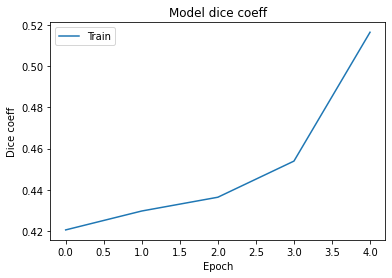

In [ ]:
if __name__ == '__main__':
  train()